# Предсказание оттока студентов на онлайн‑курсе

**Цель проекта:** построить модель, которая по первым дням активности студента на платформе предсказывает, завершит ли он курс (наберёт > 40 баллов).

**Данные:** лог событий курса (просмотры, попытки, успешные и неуспешные сабмиты) за *первые 2–3 дня* активности каждого пользователя.

**Бизнес‑ценность:** модель позволяет заранее выявлять “риск” ухода студента, чтобы своевременно предложить помощь и увеличить показатель завершения обучения.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
%matplotlib inline

from sklearn.model_selection import cross_val_score

from IPython.core.display import HTML

HTML("<style>table {font-size: 5px;}</style>")



events_train.csv - данные о действиях, которые совершают студенты со стэпами

* step_id - id стэпа
* user_id - анонимизированный id юзера
* timestamp - время наступления события в формате unix date
* action - событие, возможные значения: 
* discovered - пользователь перешел на стэп
* viewed - просмотр шага,
* started_attempt - начало попытки решить шаг, ранее нужно было явно нажать на кнопку - начать решение, перед тем как приступить к решению практического шага
* passed - удачное решение практического шага

submissions_train.csv - данные о времени и статусах сабмитов к практическим заданиям

* step_id - id стэпа
* timestamp - время отправки решения в формате unix date
* submission_status - статус решения
* user_id - анонимизированный id юзера

Многие онлайн-курсы сталкиваются с одной и той же проблемой: большое количество студентов записываются на курс, но успешно завершают его лишь 5–10%. Перед нами стоит задача — не меняя содержание курса, увеличить долю студентов, которые доходят до конца.

Для этого необходимо проанализировать поведение студентов: как часто они заходят на платформу, с какой скоростью проходят шаги, на каких этапах чаще всего возникают трудности или происходит отток. Сравнение поведения студентов, завершивших курс, и тех, кто его бросил, может помочь выявить ключевые факторы, влияющие на успешное завершение.

Интересное направление — построить предсказательную модель, которая уже в первые дни после начала обучения будет оценивать вероятность того, завершит ли студент курс. Такая модель может стать основой для раннего вмешательства: если система "заметит", что студент находится в группе риска, ему можно своевременно предложить помощь, дополнительную мотивацию или поддержку. Это позволит повысить вовлечённость и, в конечном итоге, увеличить завершение курса без изменения его содержания.

In [3]:
# Загрузка данных
events_data = pd.read_csv('https://stepik.org/media/attachments/course/4852/event_data_train.zip')
submissions_data = pd.read_csv('https://stepik.org/media/attachments/course/4852/submissions_data_train.zip')    

📌 Преобразование временных меток
Так как в данных все события указаны в формате Unix time (в секундах), мы преобразуем их в формат datetime с помощью pd.to_datetime()

In [4]:
# Преобразуем timestamp в формат datetime
submissions_data['date'] = pd.to_datetime(submissions_data.timestamp, unit='s')
events_data['date'] = pd.to_datetime(events_data.timestamp, unit='s')
# Извлекаем только дату (без времени)
submissions_data['day'] = submissions_data.date.dt.date 
events_data['day'] = events_data.date.dt.date 

✅ 1. Анализ количества успешно пройденных шагов

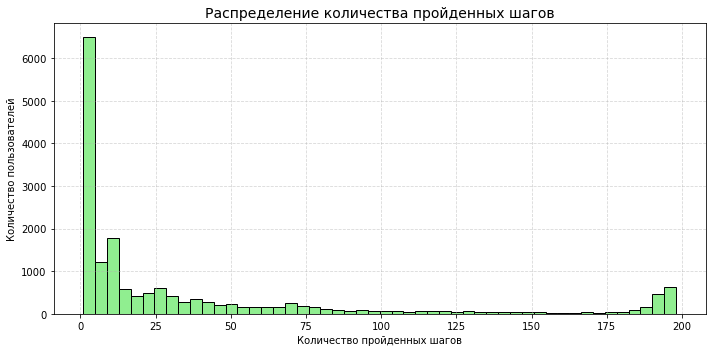

In [5]:
# Строим распределение количества пройденных шагов для оценки вовлечённости студентов

# Отбираем события типа "passed", группируем по пользователю и считаем количество пройденных шагов
events_data[events_data.action == 'passed'] \
    .groupby('user_id', as_index=False) \
    .agg({'step_id': 'count'}) \
    .rename(columns={'step_id': 'passed_steps'}) \
    .passed_steps.hist(figsize=(10, 5), bins=50, color='lightgreen', edgecolor='black')

plt.title('Распределение количества пройденных шагов', fontsize=14)
plt.xlabel('Количество пройденных шагов')
plt.ylabel('Количество пользователей')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Большинство студентов завершили совсем небольшое количество шагов, что ожидаемо: это отражает общую тенденцию низкой вовлечённости в онлайн-обучении. Далее мы исследуем поведенческие интервалы между днями активности, чтобы формализовать понятие "дропаут".

✅ 2. Подготовка данных: учёт активности по дням

In [6]:
# Выделяем только нужные столбцы
# Удаляем дубликаты: если пользователь был активен хотя бы раз в день — считаем его активным в этот день

cleaned_events = events_data[['user_id', 'day', 'timestamp']].drop_duplicates(subset=['user_id', 'day'])
cleaned_events.head()

,user_id,day,timestamp
0,17632,2015-06-15,1434340848
36,12494,2015-06-15,1434341931
59,442,2015-06-15,1434342029
62,22254,2015-06-15,1434342042
94,6646,2015-06-15,1434342230


В течение одного дня у пользователя может быть множество событий. Нам важно зафиксировать только факт активности в конкретный день, а не её количество. Поэтому мы оставляем по одному событию на день для каждого пользователя.

✅ 3. Получение таймстемпов и расчёт временных промежутков

In [7]:
# Группируем данные по пользователю, собираем список дней, когда он был активен
# Затем считаем разницу между последовательными днями (в секундах)

gap_data = (
    cleaned_events
    .groupby('user_id')['timestamp']
    .apply(list)
    .apply(np.diff)
    .values
)

# Преобразуем в один столбец и переводим в дни
gap_data = pd.Series(np.hstack(gap_data)) / (24 * 60 * 60)
gap_data.head()

0    56.060208
1    79.852419
2     2.112083
3     1.084606
4    32.047106
dtype: float64

Теперь у нас есть список всех временных промежутков между посещениями курса для каждого пользователя. Мы перевели значения из секунд в дни, чтобы лучше интерпретировать их.

✅ 4. Построение распределения интервалов между визитами

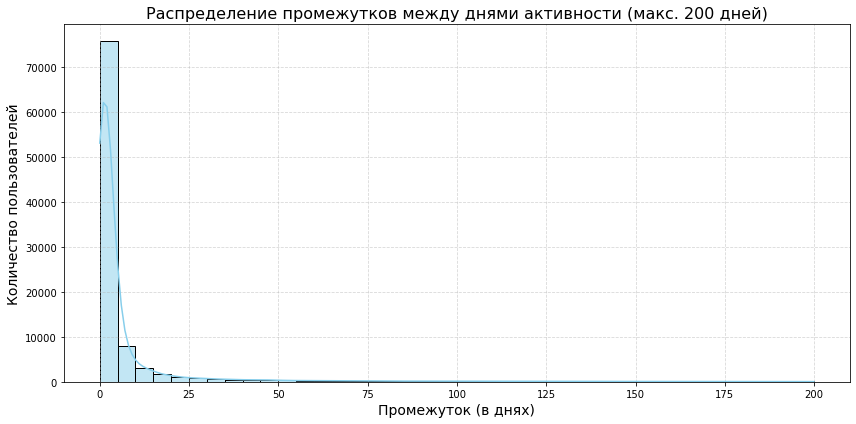

In [8]:
# Строим гистограмму временных промежутков между днями активности
# Ограничиваем максимумом в 200 дней для визуальной ясности

plt.figure(figsize=(12, 6))
sns.histplot(gap_data[gap_data <= 200], bins=40, kde=True, color='skyblue', edgecolor='black')

plt.title('Распределение промежутков между днями активности (макс. 200 дней)', fontsize=16)
plt.xlabel('Промежуток (в днях)', fontsize=14)
plt.ylabel('Количество пользователей', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Распределение показывает, что у большинства студентов между активными днями были небольшие перерывы. Однако встречаются и очень длинные промежутки, что характерно для тех, кто забросил курс.

✅ 5. Принятие решения о пороге дропаутов

In [9]:
# Определим на основе данных, какой интервал можно считать "слишком долгим", 
# чтобы пользователь уже не вернулся

print(gap_data.quantile(0.95))
print(gap_data.quantile(0.90))

59.760440972222156
18.325995370370403


На основе анализа распределения времени возврата пользователей после последнего действия на платформе:

- 90% пользователей возвращаются в течение 18 дней;

- Мы рассматриваем разумный промежуток между 18 и 60 днями (так как 60 дней — это верхняя граница "редких" возвратов);

- В итоге принимаем 30 дней как порог, после которого пользователь считается ушедшим `(is_gone_user = True)`.

- Такое решение позволяет с одной стороны не списывать слишком рано временно отсутствующих, а с другой — не затягивать с фиксацией дропаута.



Важный момент: Если студент не поясляется на курсе но при этом он уже окончил курс и получил сертификат то он уже не явояется дропнувшимся.
Условие: Студент не получил сертификат при этом не появляется на курсе больше чем на 30 дней то будем считать дропнувшимся.

### ⏰ Определение «выпавших» пользователей (дропаутов)

На этом этапе мы добавляем признаки, связанные с завершением или прекращением участия в курсе:

1. **`last_timestamp`** — для каждого пользователя определяем, когда он в последний раз был активен.
2. **`is_gone_user`** — проверяем, прошло ли больше 30 дней с последней активности до конца курса.
   - Если да, пользователь, скорее всего, **уже не вернётся**.
3. **`is_dropout`** — финальный бинарный признак:
   - `True`, если пользователь давно не появлялся **и** при этом **не прошёл курс**.
   - Это целевая переменная, которую удобно использовать при моделировании оттока.

Добавление этих признаков позволяет сегментировать пользователей и выявлять потенциальных дропаутов.


In [10]:
# Для каждого пользователя определяем время его последней активности.
user_data = events_data.groupby('user_id', as_index=False) \
            .agg({'timestamp': 'max'}).rename(columns={'timestamp': 'last_timestamp'})

# Указываем максимальный таймстемп в курсе — это конец курса.
now = 1526772811

# Порог дропаута: 30 дней в секундах.
drop_out_threshold = 30 * 24 * 60 * 60

# Вычисляем, прошло ли больше 30 дней с последнего посещения.
user_data['is_gone_user'] = (now - user_data.last_timestamp) > drop_out_threshold

# Просматриваем первые строки с новым признаком.
user_data.head(3)

,user_id,last_timestamp,is_gone_user
0,1,1472827464,True
1,2,1519226966,True
2,3,1444581588,True


### 📊 Формирование финального датасета `user_data`

На этом этапе мы собираем все ключевые данные о пользователях в одну таблицу. Вот что происходит:

1. **Объединение с таблицей `users_scores`** — добавляем информацию о набранных баллах.
2. **Заполнение пропусков нулями** — важно для корректной работы последующих операций и моделей.
3. **Агрегация действий пользователей**:
   - Считаем, сколько раз пользователь выполнял каждое из действий: `viewed`, `started_attempt`, `passed`, `discovered`.
   - Эти действия помогают понять активность и вовлечённость пользователя.
4. **Подсчёт уникальных дней активности** — сколько дней пользователь вообще был активен на платформе.
5. **Создание целевого признака `passed_course`**:
   - Если пользователь завершил более 170 шагов, считаем, что он прошёл курс.
   - Это бинарный флаг, который удобно использовать при обучении моделей (например, классификатора).
6. **Получение первых строк таблицы** — быстрая проверка структуры и наполнения данных.

В результате мы получаем финальный датасет `user_data`, готовый к анализу, визуализациям и машинному обучению.

In [11]:
# 📊 Строим сводную таблицу успеваемости пользователей
# -----------------------------------------------------
# Для каждого user_id считаем количество попыток по статусам (correct и wrong).
# Это даст понимание, насколько успешно пользователь решает задания.

# - fill_value=0: заменяет пропуски (если пользователь не делал попыток одного из типов) на 0
# - reset_index(): возвращает user_id из индекса в обычную колонку

users_scores = submissions_data.pivot_table(
    index='user_id',
    columns='submission_status',
    values='step_id',
    aggfunc='count',
    fill_value=0
).reset_index()

# Объединяем user_data с таблицей users_scores по user_id, чтобы добавить информацию о баллах пользователей.
user_data = user_data.merge(users_scores, on='user_id', how='outer')

# Заполняем пропущенные значения нулями — особенно важно, если некоторые пользователи отсутствуют в отдельных источниках.
user_data = user_data.fillna(0)

# Формируем сводную таблицу с количеством действий каждого пользователя.
users_events_data = events_data.pivot_table(
    index='user_id',        # Группируем по пользователю.
    columns='action',       # Разворачиваем тип действия в отдельные столбцы: viewed, passed, started_attempt, discovered.
    values='step_id',       # Считаем количество действий по step_id.
    aggfunc='count',        # Считаем общее количество действий каждого типа.
    fill_value=0            # Если действий не было — подставляем 0.
).reset_index()

# Объединяем данные о действиях с основной таблицей user_data.
user_data = user_data.merge(users_events_data, how='outer')

# Считаем, в скольких уникальных днях принимал участие каждый пользователь.
user_days = events_data.groupby('user_id').day.nunique().to_frame().reset_index()

# Добавляем этот показатель (кол-во дней активности) в user_data.
user_data = user_data.merge(user_days, on='user_id', how='outer')

# Добавляем бинарный признак: прошёл ли пользователь курс.
# Если количество завершённых шагов (passed) больше 170, считаем, что курс пройден.
user_data['passed_course'] = user_data.passed > 170

# Просматриваем первые 3 строки итогового датафрейма.
user_data.head(3)

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_course
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False


In [12]:
#Проверка! Не потеряли мы данные
user_data.user_id.nunique()

19234

In [13]:
# Количество наших данных совпадают
events_data.user_id.nunique()

19234

In [14]:
# Проверка согласованности данных с отраслевыми показателями.
# В среднем по индустрии онлайн-обучения только 5–10% студентов завершают курс.
# У нас курс прошли 1425 пользователей из 17 809 — это примерно 8%, что подтверждает общую тенденцию.
completion_rate = 100 * 1425 / 17809
print(f'Доля студентов, завершивших курс: {completion_rate:.2f}%')

Доля студентов, завершивших курс: 8.00%


Но всё же текущий датафрейм не так полезен, как хотелось бы.
Мы имеем полную историю действий каждого студента, но это не особенно помогает понять, на каком именно этапе что-то пошло не так. Было бы гораздо ценнее научиться предсказывать, покинет ли студент курс — и сделать это как можно раньше.

Представим, что мы возьмём агрегированные характеристики по каждому пользователю за первую неделю обучения:

- сколько уникальных дней он был активен,

- сколько у него было успешных и неуспешных сабмитов,

- сколько баллов он набрал,
и так далее.

Если на основе этих данных мы сможем с достаточной точностью предсказать, дойдёт ли студент до конца курса, то у нас появится возможность вовремя вмешаться. Например, если система предсказывает, что студент может скоро уйти, мы можем помочь ему уже на первой неделе:
— предложить подсказку,
— подбодрить,
— или объяснить сложную тему, если он, скажем, уже 5 раз не может решить задание.

Такой подход может предотвратить "отвал" студента и вернуть его обратно в процесс обучения.

### ⏰ Подбираемся к Mashine Learning задаче

Попробуем проанализировать поведение пользователей за первые несколько дней мы предскажем правда ли что студент курс успешно закончит или покинет его. Только пока мы незнаем сколько дней нам нужно чтобы предсказать поведение. Поэтому пробуем разные варианты и попытаемся нащупать время и качество. Думаю первые 2 недели будет слишком поздно для предсказания а вот первые 24 часа возможно но можем потерять в точности. Поэтому можно пока поэскпериментировать и начнем с 3 дней

In [15]:
# 3 дня, посмотрим насколько это адекватно и выведим уникальные дни прохождение курса
user_data[user_data['passed_course']==True].day.median()

20.0

🔹 1. Получаем время первого действия каждого пользователя

In [16]:
user_min_time = events_data.groupby('user_id')\
                .agg({'timestamp': 'min'})\
                .rename(columns={'timestamp':'min_timetamp'}).reset_index()

# 👉 Для каждого user_id находим минимальный timestamp — момент первого действия пользователя на платформе.
# Это нужно, чтобы отсчитывать 3 дня именно с его старта, а не с общего начала курса.

🔹 2. Объединяем это с user_data, чтобы добавить каждому пользователю дату старта

In [17]:
user_data = user_data.merge(user_min_time, on='user_id', how='outer')
# 👉 Добавляем колонку min_timetamp в user_data, чтобы позже использовать её для создания признаков.

🔹 3. Цель — отобрать события, произошедшие в первые 3 дня с момента старта пользователя

In [18]:
events_data['user_time'] = events_data.user_id.map(str) + '_' + events_data.timestamp.map(str)
# 👉 Создаём строку вида user_id_timestamp — удобная «метка времени» для фильтрации.

learning_time_threshold = 3 * 60 * 60 * 24
# 👉 3 дня в секундах = 259200 секунд. Это наш лимит.

🔹 4. Строим пороговую метку времени на 3 дня вперёд от момента старта

In [19]:
user_learning_time_threshold = user_min_time.user_id.map(str) + '_' + \
(user_min_time.min_timetamp + learning_time_threshold).map(str)
user_min_time['user_learning_time_threshold'] = user_learning_time_threshold

# 👉 Для каждого пользователя создаём строку user_id_timestamp_+_3дня, чтобы потом сравнить с user_time.

🔹 5. Объединяем с events_data и фильтруем по 3-дневному порогу

In [20]:
events_data = events_data.merge(user_min_time[['user_id', 'user_learning_time_threshold']], how='outer')
events_data_train = events_data[events_data.user_time <= events_data.user_learning_time_threshold]
# 👉 Теперь у нас есть только те события, которые произошли в первые 3 дня активности каждого пользователя.
# Эти данные будут использоваться как тренировочные признаки.


events_data_train.groupby('user_id').day.nunique().max()
# 👉 Проверка: убедиться, что фильтрация сработала — максимум 3 дня на пользователя.

4

🔹 7. Повторяем ту же фильтрацию для данных submissions_data

In [21]:
submissions_data['user_timestamp'] = submissions_data.user_id.map(str) + '_' + submissions_data.timestamp.map(str)
submissions_data = submissions_data.merge(user_min_time[['user_id', 'user_learning_time_threshold']], how='outer')
submissions_data_train = submissions_data[submissions_data.user_timestamp <= submissions_data.user_learning_time_threshold]
submissions_data_train.groupby('user_id').day.nunique().max()

# 👉 Всё то же самое, только теперь мы отбираем попытки сдачи заданий в первые 3 дня.
# Формируем обучающую выборку из данных submissions_data.

4

In [22]:
user_data

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_course,min_timetamp
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False,1472827464
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False,1514383364
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False,1434358476
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False,1466156809
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False,1521634660
...,...,...,...,...,...,...,...,...,...,...,...,...
19229,26790,1517495987,True,1.0,0.0,8,8,1,9,4,False,1451484016
19230,26793,1510225034,True,0.0,0.0,1,0,1,1,1,False,1510225031
19231,26794,1512035039,True,33.0,9.0,69,69,34,180,9,False,1495287049
19232,26797,1509995096,True,2.0,0.0,10,10,2,13,2,False,1508425316


In [23]:
user_data['passed_course'].value_counts(normalize=True)

False    0.925912
True     0.074088
Name: passed_course, dtype: float64

### Начинаем заполнять наши датафрейм X

In [24]:
# Группируем данные по user_id и считаем количество уникальных дней, в которые пользователь отправлял решения.
# Это даст нам представление о том, сколько дней пользователь был активен.
X = submissions_data_train.groupby('user_id').day.nunique().to_frame().reset_index()\
                           .rename({'day' : 'days'}, axis=1)

In [25]:
# Считаем, сколько уникальных шагов пытался решить каждый пользователь (неважно успешно или нет).
# Это показывает, насколько активно пользователь работал с контентом.
step_tried = submissions_data_train.groupby('user_id').step_id.nunique().to_frame().reset_index()\
             .rename({'step_id' : 'step_tried'}, axis=1)

In [26]:
# Объединяем данные по количеству активных дней и числу попыток решить шаги.
X = X.merge(step_tried, on='user_id', how='outer')

In [27]:
# Добавляем в таблицу количество успешных и неуспешных попыток по каждому пользователю.
# submission_status — это либо 'correct', либо 'wrong'. Считаем количество каждого типа по user_id.

X = X.merge(submissions_data_train.pivot_table(index='user_id', 
                                   columns='submission_status',   
                                   values='step_id', 
                                   aggfunc='count',
                                   fill_value=0
                                  ).reset_index())

In [28]:
# 📊 Добавляем новый признак: доля правильных решений (accuracy).
# ---------------------------------------------------------------
# Для каждого пользователя считаем отношение количества correct к общему числу попыток (correct + wrong).
# Это показатель того, насколько точно студент решал задания.

X['correct_ratio'] = round(X.correct / (X.correct + X.wrong), 2)

In [29]:
# Добавляем число просмотров шагов (действие "viewed") из events_data_train.
# Остальные действия не нужны, поэтому оставляем только колонку 'viewed'.
X = X.merge(events_data_train.pivot_table(index='user_id', 
                              columns='action', 
                              values='step_id', 
                              aggfunc='count').reset_index()[['user_id', 'viewed']], how='outer')


In [30]:
# Заполняем пропущенные значения нулями. Это нужно, чтобы не было NaN у пользователей,
# у которых, например, нет отправленных решений или просмотров.
X = X.fillna(0)

In [31]:
# Добавляем в таблицу информацию, закончил ли пользователь курс и ушёл ли он с платформы.
X = X.merge(user_data[['user_id', 'is_gone_user', 'passed_course']], how='outer')

In [32]:
# Фильтруем таблицу: оставляем только тех пользователей, статус которых нам ясен.
# Удаляем тех, кто не бросил курс (is_gone_user == False), но и не закончил его (passed_course == False).
# Они "зависшие", не завершили и не ушли — по ним сложно делать вывод.
X = X[~((X.is_gone_user == False) & (X.passed_course == False))]

In [33]:
X.groupby(['is_gone_user', 'passed_course']).user_id.count()

is_gone_user  passed_course
False         True               141
True          False            16560
              True              1284
Name: user_id, dtype: int64

In [34]:
# Создаём целевой признак y — переведём булевы значения 'passed_course' в 0/1
# 1 — если студент закончил курс, 0 — если нет
y = X.passed_course.map(int)

In [35]:
# Убираем из признаков колонки, которые содержат целевую переменную или лишние данные:
# - 'passed_course' — она теперь в y, поэтому не нужна в X
# - 'is_gone_user' — признак статуса ухода, который мы не будем использовать как признак модели
X = X.drop(['is_gone_user', 'passed_course'], axis=1)

In [36]:
# Устанавливаем 'user_id' как индекс таблицы X, чтобы удобно обращаться к строкам по пользователям
X = X.set_index(X.user_id)

# После установки индекса, удаляем колонку 'user_id', чтобы не дублировать информацию
X = X.drop(['user_id'], axis=1)

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score

In [39]:
# Разбиваем данные на обучающую и тестовую выборки
# stratify=y — чтобы сохранить пропорции классов в обеих выборках
# shuffle=True — перемешиваем данные перед разбиением для случайности
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y, shuffle=True)

# Создаем пустой DataFrame для хранения результатов экспериментов с параметрами модели
scores_data = pd.DataFrame(columns=[ 'train_score', 'test_score', 'overfit_gap',
                                    'precision', 'recall', 'f1', 'roc_auc'])

# В цикле пытаемся подобрать параметры модели Decision Tree вручную,
# так как GridSearchCV на этом наборе данных работает слишком медленно.
# Здесь перебрал каждый параметр.
for max_depth in range(1, 300): 
    model = DecisionTreeClassifier(criterion='entropy',
                                   max_depth=6, 
                                   random_state=41, 
                                   min_samples_leaf=273,
                                   min_samples_split=70,
                                   class_weight='balanced')
    model.fit(X_train, y_train)
    # accuracy
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    
    overfit = train_score - test_score
    
    # roc-auc
    y_proba = model.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, y_proba)
    
    # предсказания
    y_pred    = model.predict(X_test)
    precision = precision_score(y_test, y_pred)
    recall    = recall_score(y_test, y_pred)
    f1        = f1_score(y_test, y_pred)

    # Добавляем результаты в Таблицу 
    scores_data.loc[len(scores_data)] = [train_score, test_score, overfit, precision,
    recall, f1, roc_auc]
    
best_row = scores_data.loc[scores_data['recall'].idxmax()]

In [40]:
best_row

train_score    0.716489
test_score     0.726040
overfit_gap   -0.009551
precision      0.203654
recall         0.845506
f1             0.328244
roc_auc        0.850798
Name: 0, dtype: float64

In [41]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score
import pandas as pd

# Список моделей
models = {
    'Decision Tree': DecisionTreeClassifier(max_depth=6, random_state=41, class_weight='balanced',
                                            min_samples_leaf=273, min_samples_split=70),
    'Random Forest': RandomForestClassifier(n_estimators=200, max_depth=6, random_state=41, class_weight='balanced'),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=41, class_weight='balanced')}

results = []

# Проходим по каждой модели, обучаем и оцениваем на тестовой выборке
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    # Вычисляем метрики качества
    roc_auc = roc_auc_score(y_test, y_proba)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    accuracy = model.score(X_test, y_test)
    
    # Собираем результаты в список словарей
    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'ROC-AUC': roc_auc,
        'Precision': precision,
        'Recall': recall,
        'F1-score': f1
    })

# Преобразуем результаты в DataFrame и выводим
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='ROC-AUC', ascending=False).reset_index(drop=True)
print(results_df)


                 Model  Accuracy   ROC-AUC  Precision    Recall  F1-score
0        Decision Tree  0.751390  0.850995   0.215672  0.811798  0.340802
1        Random Forest  0.769179  0.849477   0.223214  0.772472  0.346348
2  Logistic Regression  0.726707  0.832170   0.202454  0.834270  0.325837


| Модель              | Accuracy | ROC-AUC | Precision | Recall | F1-score |
| ------------------- | -------- | ------- | --------- | ------ | -------- |
| Random Forest       | 0.77     | 0.85    | 0.22      | 0.77   | 0.35     |
| Decision Tree       | 0.75     | 0.85    | 0.22      | 0.81   | 0.34     |
| Logistic Regression | 0.73     | 0.83    | 0.20      | 0.83   | 0.33     |


* Все три модели показываю хорошее качество с точки зрения roc-auc 0.85. Это отличный способ отличать студентов которые завершат курс, от тех, кто его бросит.

* Random Forest показал самый высокий показатель точности -- 0.77 что говорит о том, что он чаще правильно классифицирует как "закончивших", так и "отвалившихся".

* Decision Tree показал самый высокий полноту 81%. Это значит, что она лучше всего обнаруживает студентов, которые действительно завершают курс, что важно, если приоритет — минимизировать пропуск успешных студентов.

* Logistic Regression немного уступает в общем качестве, но имеет самый высокий Recall (83%), то есть хорошо находит тех, кто закончит курс, хотя при этом точность ниже.

* Значения Precision у всех моделей низкие (около 20-22%), что указывает на высокий уровень ложных срабатываний. В данном контексте это означает, что модели часто ошибочно прогнозируют, что студент завершит курс, хотя он этого не делает. Это может быть следствием сильного дисбаланса классов.

* F1-score — гармоническое среднее Precision и Recall — около 0.33–0.35 у всех моделей, что указывает на компромисс между полнотой и точностью.

* Низкие значения Precision (~20%) указывают на высокое число ложных срабатываний — модели часто ошибочно предсказывают успешное завершение курса. Это связано с дисбалансом классов в данных.

#### Неудачные попытки и особенности работы с данными


* Я пробовал использовать SMOTE для балансировки классов, но это привело к снижению ROC-AUC.

* Попытки тонко подбирать параметры с помощью GridSearchCV были ограничены из-за ограниченных вычислительных ресурсов.

* Также пробовал балансировку порогов классификации, что снижало ROC-AUC.

* Показатель ROC-AUC выбран как основная метрика, так как он учитывает качество ранжирования и был ключевым в соревновании, на котором базируется задача.

* Добавлял и убавлял признаки

* Пробовал более сложные модели как Градиент

---

## Выводы

- Построены признаки активности студентов за первые дни (количество сабмитов, просмотров, уникальных дней активности и др.).
- Обучено несколько моделей (Decision Tree, Random Forest, Logistic Regression).
- Лучшая модель показывает ROC‑AUC ≈ 0.85 — это хороший показатель разделения между “завершающими” и “отваливающимися” студентами.
- Попытки улучшить модель через SMOTE (балансировка классов), GridSearch и изменение порогов ухудшали ROC‑AUC, поэтому выбрано базовое дерево решений с подбором параметров вручную.
- Такую модель можно встроить в LMS‑платформу: если вероятность ухода > 0.7, студенту показывается подсказка, мотивационное сообщение или дополнительный учебный материал.

**Потенциал развития:**
- Пробовать Gradient Boosting / CatBoost
- Уточнять признаки вовлечённости
- Добавлять персональные рекомендации для удержания

